In [256]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [257]:
# def preprocess_barcode(image):
#     # Step 1: Denoise the image using Gaussian blur
#     denoised = cv2.GaussianBlur(image, (5, 5), 0)

#     # Step 2: Binarize the image (convert to black and white)
#     _, binary = cv2.threshold(denoised, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

#     median_denoised = cv2.medianBlur(binary, 5)


#     # Step 3: Detect edges using Sobel filter
#     sobelx = cv2.Sobel(median_denoised, cv2.CV_64F, 1, 0, ksize=3)
#     sobelx = cv2.convertScaleAbs(sobelx)

#     # Step 4: Close gaps in the bars using morphological closing
#     kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
#     closed = cv2.morphologyEx(sobelx, cv2.MORPH_CLOSE, kernel)

    
    
#     # Step 5: Find contours and crop the barcode region
#     contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     if contours:
#         largest_contour = max(contours, key=cv2.contourArea)
#         x, y, w, h = cv2.boundingRect(largest_contour)
#         cropped = binary[y:y + h, x:x + w]
#         # cropped = cv2.medianBlur(cropped, 5)
#     else:
#         cropped = binary  
        
#     # Step 5: Remove small artifacts using morphological opening
#     kernel_clean = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
#     cleaned = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel_clean)


#     return binary, cleaned, cropped



def preprocess_barcode(image):
    # Step 1: Detect the finger (skin color) and mask it out
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_skin = np.array([0, 20, 70], dtype=np.uint8) 
    upper_skin = np.array([20, 255, 255], dtype=np.uint8)
    skin_mask = cv2.inRange(hsv_image, lower_skin, upper_skin)
    
    # Threshold the skin mask to remove the finger region
    _, binary_skin_mask = cv2.threshold(skin_mask, 127, 255, cv2.THRESH_BINARY_INV)
    
    # Mask the image to remove the finger region
    masked_image = cv2.bitwise_and(image, image, mask=binary_skin_mask)
    
    # Convert the masked image to grayscale
    gray_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)
    
    # Denoise the grayscale image using Gaussian blur
    denoised = cv2.GaussianBlur(gray_image, (5, 5), 0)
    
    # Binarize the image using Otsu's method
    _, binary = cv2.threshold(denoised, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Clean up the binary image
    median_denoised = cv2.medianBlur(binary, 5)
    
    # Detect edges using the Sobel filter
    sobelx = cv2.Sobel(median_denoised, cv2.CV_64F, 1, 0, ksize=3)
    sobelx = cv2.convertScaleAbs(sobelx)
    
    # Close gaps in the barcode lines
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
    closed = cv2.morphologyEx(sobelx, cv2.MORPH_CLOSE, kernel)
    
    # Remove small artifacts
    kernel_clean = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    cleaned = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel_clean)
    
    # Find contours and crop the barcode region
    contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        cropped = binary[y:y + h, x:x + w]
    else:
        cropped = binary
    # Step 3: Apply vertical closing to fill gaps in vertical lines
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 160))  # (width, height)
    vertical_closed = cv2.morphologyEx(cropped, cv2.MORPH_CLOSE, vertical_kernel)
    
    return binary, cleaned, vertical_closed






In [258]:
def fix_discontinuous_lines(cropped_image):
    # Detect edges in the cropped image
    edges = cv2.Canny(cropped_image, 50, 150, apertureSize=3)

    # Detect lines using Hough Line Transform
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=30, maxLineGap=10)

    # Create a blank mask for drawing lines
    line_mask = np.zeros_like(cropped_image)

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(line_mask, (x1, y1), (x2, y2), 255, 2)  # Draw white lines on the mask

    # Fill gaps in the black lines by inverting the cropped image
    inverted_cropped = cv2.bitwise_not(cropped_image)
    black_line_mask = cv2.bitwise_and(inverted_cropped, line_mask)

    # Combine the original image with the black line mask
    filled_black_lines = cv2.bitwise_or(cropped_image, black_line_mask)

    # Apply morphological closing to fill small gaps in white spaces
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    smoothed = cv2.morphologyEx(filled_black_lines, cv2.MORPH_CLOSE, kernel)

    # Restore white spaces correctly
    final_output = cv2.bitwise_or(smoothed, line_mask)

    return final_output




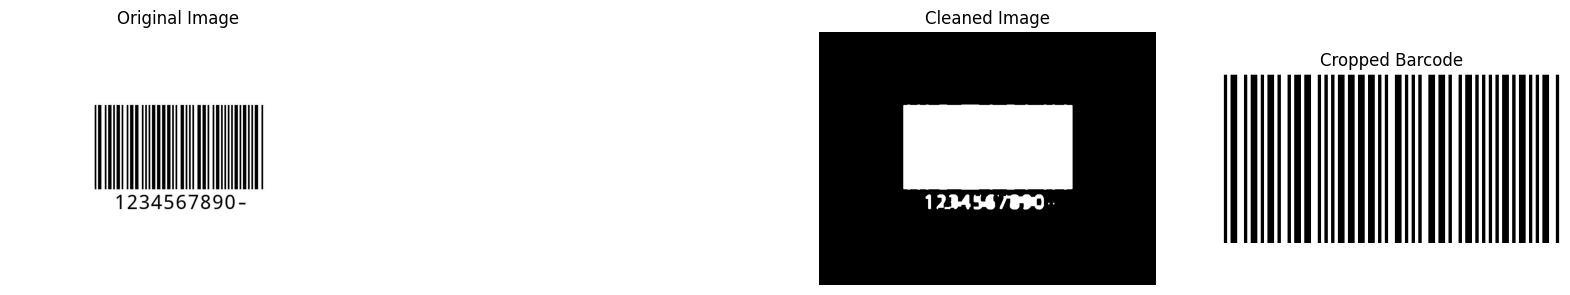

In [259]:
image_path = "Test Cases\\01 - lol easy.jpg"  
image = cv2.imread(image_path)

# Preprocess the barcode
binary, cleaned, cropped = preprocess_barcode(image)

# Visualize the results
plt.figure(figsize=(20, 5))

# Original Image
plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")



# Cleaned Image (After Morphological Processing)
plt.subplot(1, 4, 3)
plt.imshow(cleaned, cmap='gray')
plt.title("Cleaned Image")
plt.axis("off")

# Cropped Barcode
plt.subplot(1, 4, 4)
plt.imshow(cropped, cmap='gray')
plt.title("Cropped Barcode")
plt.axis("off")

plt.show()

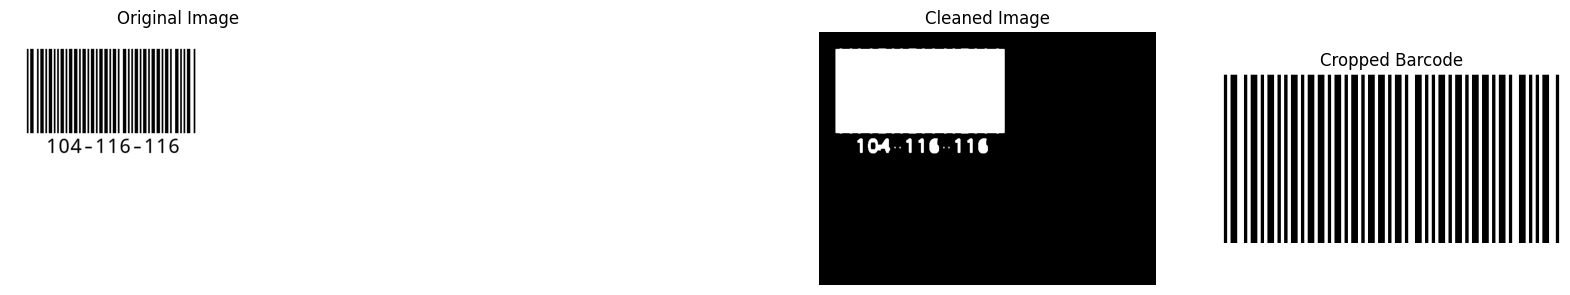

In [260]:
image_path = "Test Cases\\02 - still easy.jpg"  
image = cv2.imread(image_path)

# Preprocess the barcode
binary, cleaned, cropped = preprocess_barcode(image)

# Visualize the results
plt.figure(figsize=(20, 5))

# Original Image
plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")



# Cleaned Image (After Morphological Processing)
plt.subplot(1, 4, 3)
plt.imshow(cleaned, cmap='gray')
plt.title("Cleaned Image")
plt.axis("off")

# Cropped Barcode
plt.subplot(1, 4, 4)
plt.imshow(cropped, cmap='gray')
plt.title("Cropped Barcode")
plt.axis("off")

plt.show()

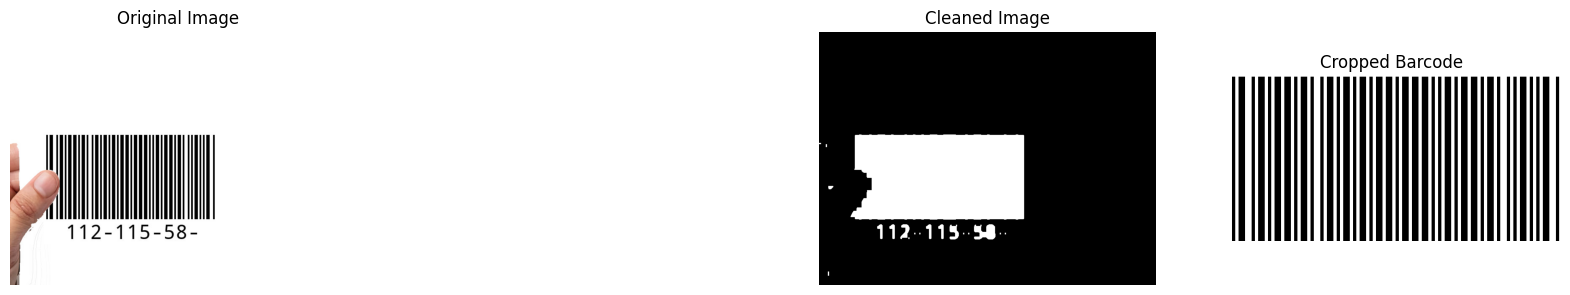

In [261]:
image_path = "Test Cases\\03 - eda ya3am ew3a soba3ak mathazarsh.jpg"  
image = cv2.imread(image_path)

# Preprocess the barcode
binary, cleaned, cropped = preprocess_barcode(image)

# Visualize the results
plt.figure(figsize=(20, 5))

# Original Image
plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")



# Cleaned Image (After Morphological Processing)
plt.subplot(1, 4, 3)
plt.imshow(cleaned, cmap='gray')
plt.title("Cleaned Image")
plt.axis("off")

# Cropped Barcode
plt.subplot(1, 4, 4)
plt.imshow(cropped, cmap='gray')
plt.title("Cropped Barcode")
plt.axis("off")

plt.show()

In [262]:
image_path = "Test Cases\\04 - fen el nadara.jpg"  
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

binary, closed, cropped = preprocess_barcode(image)


plt.figure(figsize=(20, 5))  

# Original Image
plt.subplot(1, 4, 1)  
plt.imshow(image, cmap='gray')
plt.title("Original Barcode Image")
plt.axis("off")

# Binarized Image
plt.subplot(1, 4, 2)  
plt.imshow(binary, cmap='gray')
plt.title("Binarized")
plt.axis("off")

# Morphologically Closed Image
plt.subplot(1, 4, 3) 
plt.imshow(closed, cmap='gray')
plt.title("After Morphological Closing")
plt.axis("off")

# Cropped Barcode
plt.subplot(1, 4, 4) 
plt.imshow(cropped, cmap='gray')
plt.title("Cropped Barcode")
plt.axis("off")


plt.show()

error: OpenCV(4.10.0) d:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<3,4,-1>,struct cv::impl::A0x9faa3a91::Set<3,-1,-1>,struct cv::impl::A0x9faa3a91::Set<0,5,-1>,4>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


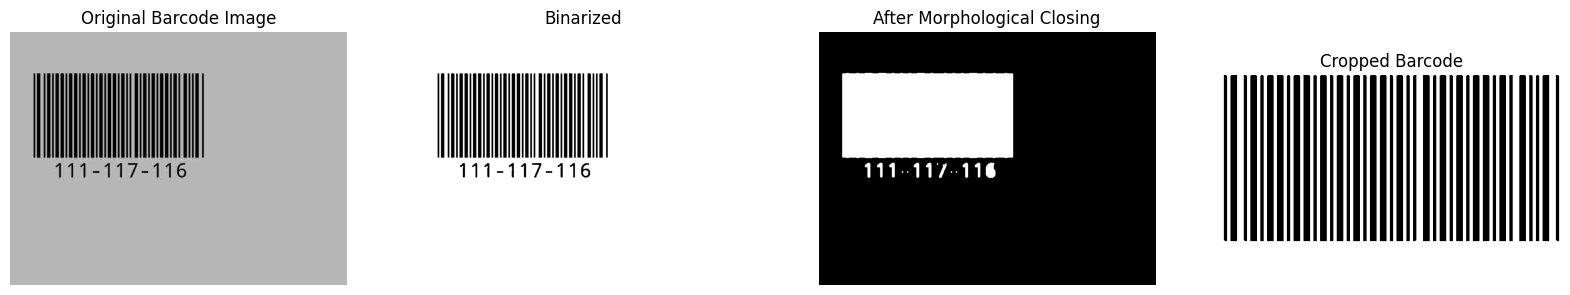

In [ ]:
image_path = "Test Cases\\05 - meen taffa el nour!!!.jpg"  
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

binary, closed, cropped = preprocess_barcode(image)


plt.figure(figsize=(20, 5))  

# Original Image
plt.subplot(1, 4, 1)  
plt.imshow(image, cmap='gray')
plt.title("Original Barcode Image")
plt.axis("off")

# Binarized Image
plt.subplot(1, 4, 2)  
plt.imshow(binary, cmap='gray')
plt.title("Binarized")
plt.axis("off")

# Morphologically Closed Image
plt.subplot(1, 4, 3) 
plt.imshow(closed, cmap='gray')
plt.title("After Morphological Closing")
plt.axis("off")

# Cropped Barcode
plt.subplot(1, 4, 4) 
plt.imshow(cropped, cmap='gray')
plt.title("Cropped Barcode")
plt.axis("off")


plt.show()

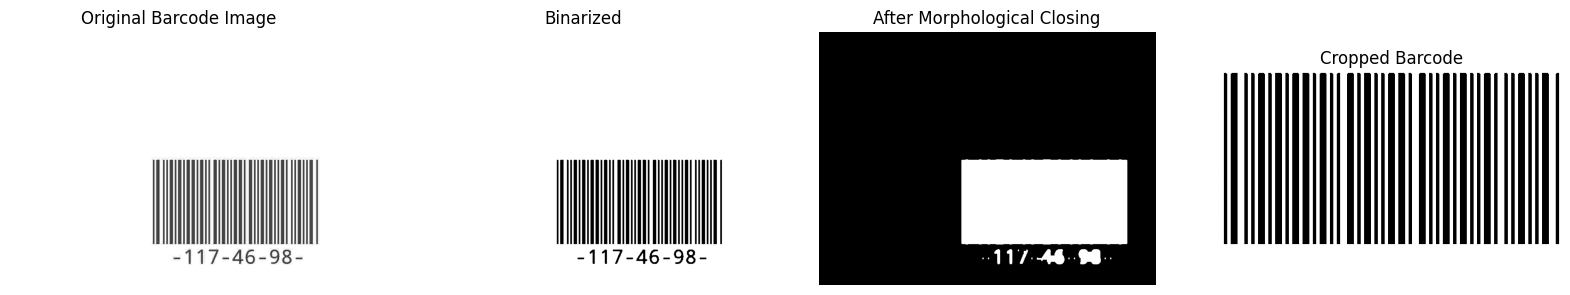

In [ ]:
image_path = "Test Cases\\06 - meen fata7 el nour 333eenaaayy.jpg"  
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

binary, closed, cropped = preprocess_barcode(image)


plt.figure(figsize=(20, 5))  

# Original Image
plt.subplot(1, 4, 1)  
plt.imshow(image, cmap='gray')
plt.title("Original Barcode Image")
plt.axis("off")

# Binarized Image
plt.subplot(1, 4, 2)  
plt.imshow(binary, cmap='gray')
plt.title("Binarized")
plt.axis("off")

# Morphologically Closed Image
plt.subplot(1, 4, 3) 
plt.imshow(closed, cmap='gray')
plt.title("After Morphological Closing")
plt.axis("off")

# Cropped Barcode
plt.subplot(1, 4, 4) 
plt.imshow(cropped, cmap='gray')
plt.title("Cropped Barcode")
plt.axis("off")


plt.show()

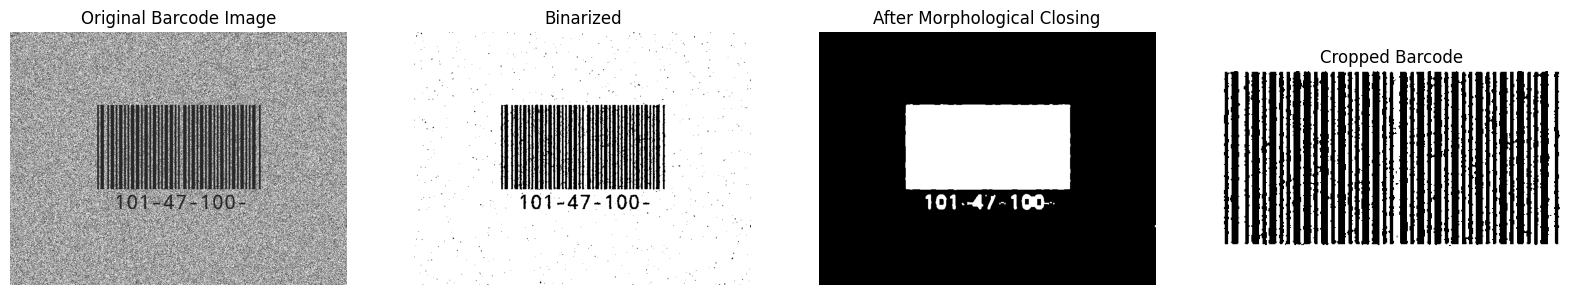

In [ ]:
image_path = "Test Cases\\07 - mal7 w felfel.jpg"  
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

binary, closed, cropped = preprocess_barcode(image)


plt.figure(figsize=(20, 5))  

# Original Image
plt.subplot(1, 4, 1)  
plt.imshow(image, cmap='gray')
plt.title("Original Barcode Image")
plt.axis("off")

# Binarized Image
plt.subplot(1, 4, 2)  
plt.imshow(binary, cmap='gray')
plt.title("Binarized")
plt.axis("off")

# Morphologically Closed Image
plt.subplot(1, 4, 3) 
plt.imshow(closed, cmap='gray')
plt.title("After Morphological Closing")
plt.axis("off")

# Cropped Barcode
plt.subplot(1, 4, 4) 
plt.imshow(cropped, cmap='gray')
plt.title("Cropped Barcode")
plt.axis("off")


plt.show()

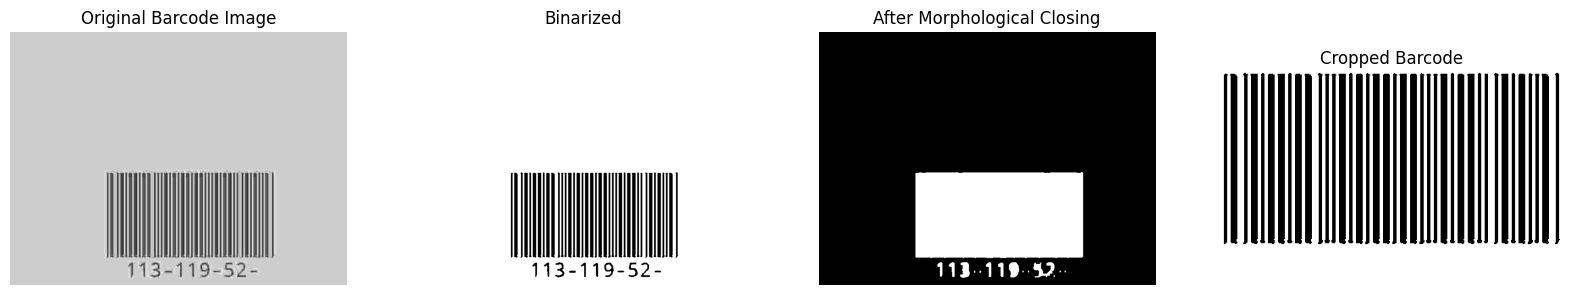

In [ ]:
image_path = "Test Cases\\08 - compresso espresso.jpg"  
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

binary, closed, cropped = preprocess_barcode(image)


plt.figure(figsize=(20, 5))  

# Original Image
plt.subplot(1, 4, 1)  
plt.imshow(image, cmap='gray')
plt.title("Original Barcode Image")
plt.axis("off")

# Binarized Image
plt.subplot(1, 4, 2)  
plt.imshow(binary, cmap='gray')
plt.title("Binarized")
plt.axis("off")

# Morphologically Closed Image
plt.subplot(1, 4, 3) 
plt.imshow(closed, cmap='gray')
plt.title("After Morphological Closing")
plt.axis("off")

# Cropped Barcode
plt.subplot(1, 4, 4) 
plt.imshow(cropped, cmap='gray')
plt.title("Cropped Barcode")
plt.axis("off")


plt.show()